## **Visualization of Neural network Architecture using [netron](https://github.com/lutzroeder/netron.git)**
### CMB $\mathcal{C}^{TT}_{\ell}$ case

In [9]:
#Import packages
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.layers.experimental.preprocessing import Normalization
from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import Adam
import math

### Read the data (simulated out of [CLASS](https://github.com/lesgourg/class_public) and the [ESA Planck Archival](https://pla.esac.esa.int/#home))

In [10]:
#Read the data
label = '_FR0_e-6_FRn'
planck_df_LCDM = np.genfromtxt('./simulated_data/TT_polarization/ttcls_MoGgrids_noisy_FR0_LCDM.csv', delimiter=',')
planck_df_MoG = np.genfromtxt('./simulated_data/TT_polarization/ttcls_MoGgrids_noisy%s.csv'%label, delimiter=',')
planck_cls_LCDM = planck_df_LCDM[1:] # get rid of the first column, i.e. multipole moment l
planck_cls_MoG = planck_df_MoG[1:]
ls = planck_df_LCDM[0]

#Add the model class: 
LCDM_class = np.zeros(len(planck_cls_LCDM))
MoG_class = np.ones(len(planck_cls_MoG))

#Full arrays (+target):
cls_LCDM_class = np.column_stack((planck_cls_LCDM, LCDM_class))
cls_MoG_class = np.column_stack((planck_cls_MoG, MoG_class))

#Full data set (LCDM + MoG)
cls_full_dataset = np.concatenate((planck_cls_LCDM, planck_cls_MoG)) #without the class: x_dataset
dataset_class = np.concatenate((LCDM_class, MoG_class)) #only the class: y_dataset
cls_full_dataset_class = np.concatenate((cls_LCDM_class, cls_MoG_class)) #with the class: xy_dataset

In [11]:
#-----------------------------------------------------------------------------------------------------------------------
#Dls
#-----------------------------------------------------------------------------------------------------------------------
# Create a function for converting the C_ls^TT to Dls Tcmb=2.7255
def Dls(l,CTT):
    Dl = [l[i]*(l[i]+1)*CTT[i]/((2*math.pi)*(2.7255*10**6)**2) for i in range(len(l))]
    return Dl
#-----------------------------------------------------------------------------------------------------------------------
#Normalization
#-----------------------------------------------------------------------------------------------------------------------
fig = plt.figure(figsize=(8,6))
normalize = Normalization()
normalize.adapt(cls_full_dataset)
normalized_data = normalize(cls_full_dataset)

<Figure size 800x600 with 0 Axes>

In [12]:
#Train_test_split
from sklearn.model_selection import train_test_split
normalized_data_numpy = normalized_data.numpy()
X_train, X_test, y_train, y_test = train_test_split(normalized_data_numpy, dataset_class, test_size=0.3, random_state=42)
#Training and validation split with fixed random seed
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

## NN architecture definition

In [13]:
from tensorflow.keras import layers, models, Input

#Input shape with a batch size of 32 and 83 Cells datapoints(features)
input_shape = (32, 83)
inputs = Input(shape=(83,), batch_size=32, name='Cells_input')

#Architecture
hidden_layer = layers.Dense(32, activation='relu', name='hidden_layer')(inputs)
dropout_layer = layers.Dropout(0.2)(hidden_layer)
outputs = layers.Dense(1, activation="sigmoid", name='output_layer')(dropout_layer)
model = models.Model(inputs=inputs, outputs=outputs, name='Angular_PS_NN')

#Compile model:
model.compile(optimizer=Adam(learning_rate=0.0002), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "Angular_PS_NN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Cells_input (InputLayer)    [(32, 83)]                0         
                                                                 
 hidden_layer (Dense)        (32, 32)                  2688      
                                                                 
 dropout_1 (Dropout)         (32, 32)                  0         
                                                                 
 output_layer (Dense)        (32, 1)                   33        
                                                                 
Total params: 2721 (10.63 KB)
Trainable params: 2721 (10.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


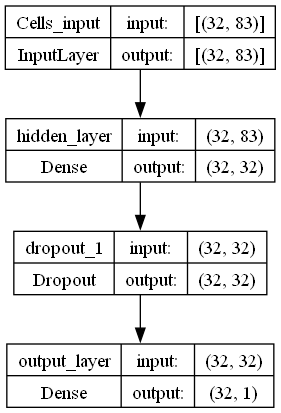

In [14]:
from tensorflow.keras.utils import plot_model
import pydot
#for this to work pip install pydot
#install graphviz.exe for windows: https://graphviz.gitlab.io/download/

plot_model(model, to_file='./figures_MoG/model_plot.png', show_shapes=True, show_layer_names=True, show_dtype=False, rankdir='TB', expand_nested=True, dpi=96, layer_range=None)

In [15]:
#Save the model:
model.save('./figures_feature/Planck_NN_model.h5')

c:\Users\indi_\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [16]:
import netron

netron.start('./figures_feature/Planck_NN_model.h5') #Architecture displayed in server

Serving './figures/Planck_NN_model.h5' at http://localhost:8080


('localhost', 8080)